        Date TradeVolume  TradeAmount OpenPrice HighPrice LowPrice ClosePrice  \
1 2021-01-04    39489959  21127581248    530.00    540.00   528.00     536.00   
2 2021-01-05    34839391  18761831567    536.00    542.00   535.00     542.00   
3 2021-01-06    55614434  30572783229    555.00    555.00   541.00     549.00   
4 2021-01-07    53392763  30018630685    554.00    570.00   553.00     565.00   
5 2021-01-08    62957148  36339702855    580.00    580.00   571.00     580.00   

  PriceDiff TradeCount  
1     +6.00      33316  
2     +6.00      28512  
3     +7.00      55462  
4    +16.00      47905  
5    +15.00      56426  
        Date TradeVolume  TradeAmount OpenPrice HighPrice LowPrice ClosePrice  \
1 2021-02-01    70161939  42004241697    595.00    612.00   587.00     611.00   
2 2021-02-02    80724207  50938461582    629.00    638.00   622.00     632.00   
3 2021-02-03    59763227  37926170035    638.00    642.00   630.00     630.00   
4 2021-02-04    47547873  29765963971  

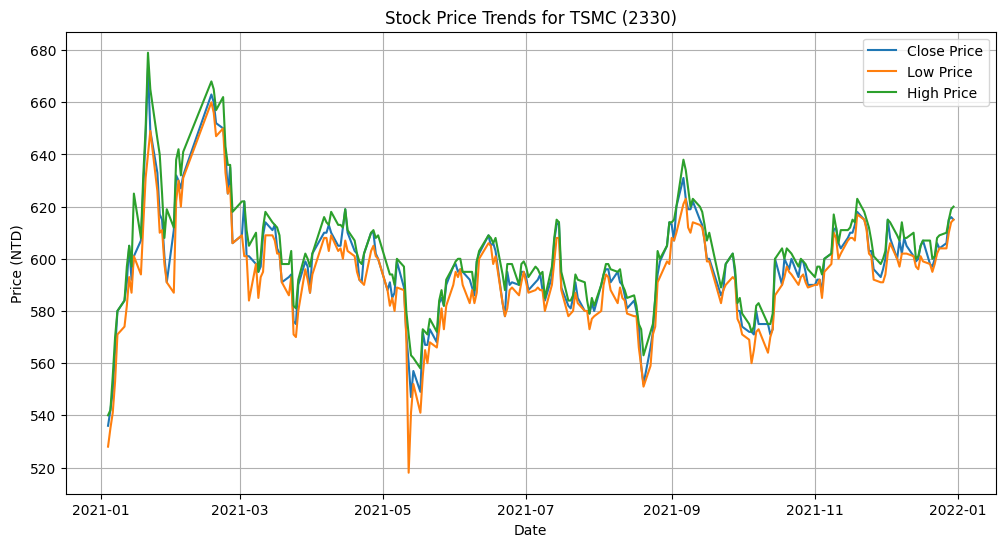

In [50]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import time

# 數據庫連接參數
server = 'localhost'  # 或 'localhost\實例名'
database = 'StockData'
driver = '{ODBC Driver 17 for SQL Server}'

# 連接到 SQL Server 使用 Windows 身份驗證
conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
cursor = conn.cursor()

# 創建股票數據表
cursor.execute('''
IF NOT EXISTS (SELECT * FROM sys.objects WHERE object_id = OBJECT_ID(N'[dbo].[StockPrices]') AND type in (N'U'))
CREATE TABLE StockPrices (
    Date DATE,
    ClosePrice FLOAT,
    LowPrice FLOAT,
    HighPrice FLOAT
)
''')
conn.commit()

# 將民國紀年轉換為公元紀年
def convert_to_gregorian(date_str):
    try:
        year, month, day = date_str.split('/')
        year = int(year) + 1911  # 將民國紀年轉換為公元紀年
        return f'{year}/{month}/{day}'
    except ValueError:
        return None

# 抓取股票數據函數
def fetch_stock_data(year, month, stock_number='2330'):
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=html&date={year}{month:02d}01&stockNo={stock_number}'
    df = pd.read_html(url, header=0)[0]

    # 重命名列
    df.columns = ['Date', 'TradeVolume', 'TradeAmount', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'PriceDiff', 'TradeCount']

    # 刪除不需要的行（如標題行和總計行）
    df = df[df['Date'] != '日期']
    df = df.dropna(subset=['Date'])
    
    # 轉換日期格式
    df['Date'] = df['Date'].apply(convert_to_gregorian)
    df = df.dropna(subset=['Date'])
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
    
    return df

# 存儲數據到數據庫
def store_data(df):
    for index, row in df.iterrows():
        cursor.execute("INSERT INTO StockPrices (Date, ClosePrice, LowPrice, HighPrice) VALUES (?, ?, ?, ?)",
                       row['Date'], row['ClosePrice'], row['LowPrice'], row['HighPrice'])
    conn.commit()

# 準備一整年的數據並存儲到數據庫和CSV文件
def prepare_full_year_data():
    df_all = pd.DataFrame()
    for month in range(1, 13):
        df_month = fetch_stock_data(2021, month)
        print(df_month.head())  # 打印數據前幾行進行調試
        store_data(df_month)
        df_all = pd.concat([df_all, df_month], ignore_index=True)
        time.sleep(2)  # 暫停2秒以避免過快訪問網站
    return df_all

# 將數據保存到CSV文件
def save_data(df, filepath='stock_data_2330.csv'):
    df.to_csv(filepath, index=False)
    print(f'Data saved to {filepath}')

# 繪製股票價格趨勢圖
def plot_stock_trends(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['ClosePrice'], label='Close Price')
    plt.plot(df['Date'], df['LowPrice'], label='Low Price')
    plt.plot(df['Date'], df['HighPrice'], label='High Price')
    plt.title('Stock Price Trends for TSMC (2330)')
    plt.xlabel('Date')
    plt.ylabel('Price (NTD)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # 爬取並保存數據
    df_year = prepare_full_year_data()
    save_data(df_year)

    # 繪圖
    plot_stock_trends('stock_data_2330.csv')

    # 清理資源
    cursor.close()
    conn.close()
